In [1]:
import os
import sys
import timeit
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.regularization import regularize_network_params, l2, l1
import gzip
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)


# Nonlinear function y = x ** 2 - 0.5 

In [2]:
def func(x):
    return 1e-5 * x ** 2 - 5

In [3]:
SIGMA = 1
data_ponits = 200

In [4]:
X = 2000 * np.random.random(size=data_ponits) - 1000
y = func(X) + SIGMA * np.random.randn(data_ponits)

X_test = 2000 * np.random.random(size=data_ponits) - 1000
y_test = func(X_test) + SIGMA * np.random.randn(data_ponits)

y = np.asarray(y, dtype=np.float32)
X = np.asarray(X, dtype=np.float32)
X = X.reshape((X.shape[0], 1))

y_test = np.asarray(y_test, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
X_test = X_test.reshape((X_test.shape[0], 1))

# Conclusion: if we random sample x to form the train set, then the MLP doesn't overfit. (as long as your sample is reasonably large, like 100 )

## for example, if we use the trainning sample below, then model won't overfit

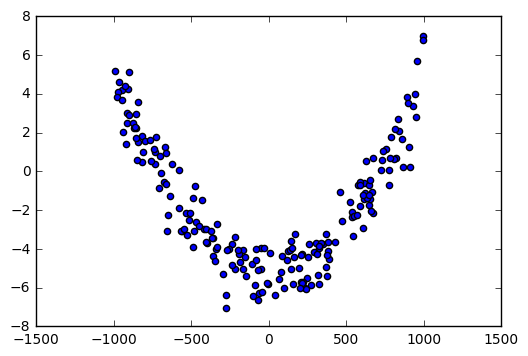

In [5]:
plt.scatter(X,y)

In [6]:
Batch_SIZE = 1

In [7]:
def build_model(input_var, hidden_neurons=1024):
    l_in = InputLayer(shape=(None, 1), input_var=input_var)
    l_hidden1 = DenseLayer(l_in, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_hidden2 = DenseLayer(l_hidden1, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_out = DenseLayer(l_hidden1, num_units=1, nonlinearity=None)
    return l_out

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [9]:
    num_epochs = 2000
    learn_rate = 0.1
    hidden_neurons = 1024
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    network = build_model(input_var, hidden_neurons)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    #l2_penalty = regularize_network_params(network, l2)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adagrad(loss, params, learning_rate=learn_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    get_output = theano.function([input_var], test_prediction)
    time_list = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, Batch_SIZE, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
            # Then we print the results for this epoch:
        time_delta = time.time() - start_time
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_delta))
        time_list.append(time_delta)
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, Batch_SIZE, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    final_train_err = train_err
    final_test_err = test_err 
    avg_epoch_time = np.mean(time_list)
    y_pred = get_output(X)
    y_test_pred = get_output(X_test)

Epoch 1 of 2000 took 0.077s
  training loss:		68.615725
Epoch 2 of 2000 took 0.077s
  training loss:		19.228093
Epoch 3 of 2000 took 0.077s
  training loss:		16.960363
Epoch 4 of 2000 took 0.085s
  training loss:		16.416229
Epoch 5 of 2000 took 0.078s
  training loss:		15.672727
Epoch 6 of 2000 took 0.077s
  training loss:		15.015721
Epoch 7 of 2000 took 0.084s
  training loss:		14.674217
Epoch 8 of 2000 took 0.078s
  training loss:		14.980854
Epoch 9 of 2000 took 0.077s
  training loss:		13.931249
Epoch 10 of 2000 took 0.087s
  training loss:		13.756110
Epoch 11 of 2000 took 0.080s
  training loss:		13.840017
Epoch 12 of 2000 took 0.080s
  training loss:		12.684810
Epoch 13 of 2000 took 0.092s
  training loss:		13.672841
Epoch 14 of 2000 took 0.083s
  training loss:		13.083650
Epoch 15 of 2000 took 0.077s
  training loss:		13.328283
Epoch 16 of 2000 took 0.085s
  training loss:		13.277037
Epoch 17 of 2000 took 0.078s
  training loss:		12.604133
Epoch 18 of 2000 took 0.080s
  training 

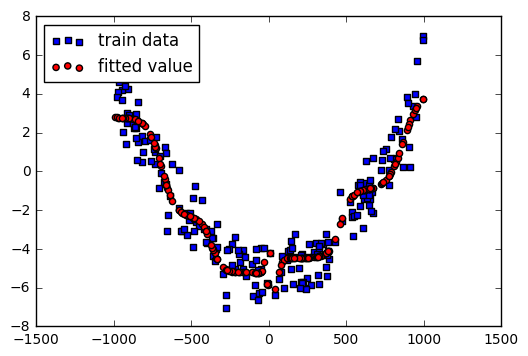

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X, y, c='b', marker="s", label='train data')
ax1.scatter(X, y_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()

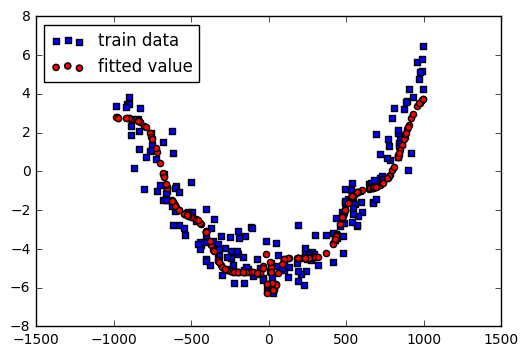

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test, y_test, c='b', marker="s", label='train data')
ax1.scatter(X_test, y_test_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()

# Deeper model:

In [21]:
def build_model(input_var, hidden_neurons=1024):
    l_in = InputLayer(shape=(None, 1), input_var=input_var)
    l_hidden1 = DenseLayer(l_in, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_hidden2 = DenseLayer(l_hidden1, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_hidden3 = DenseLayer(l_hidden2, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_hidden4 = DenseLayer(l_hidden3, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_out = DenseLayer(l_hidden1, num_units=1, nonlinearity=None)
    return l_out

In [22]:
    num_epochs = 2000
    learn_rate = 0.1
    hidden_neurons = 1024
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    network = build_model(input_var, hidden_neurons)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    #l2_penalty = regularize_network_params(network, l2)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adagrad(loss, params, learning_rate=learn_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    get_output = theano.function([input_var], test_prediction)
    time_list = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, Batch_SIZE, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
            # Then we print the results for this epoch:
        time_delta = time.time() - start_time
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_delta))
        time_list.append(time_delta)
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, Batch_SIZE, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    final_train_err = train_err
    final_test_err = test_err 
    avg_epoch_time = np.mean(time_list)
    y_pred = get_output(X)
    y_test_pred = get_output(X_test)

Epoch 1 of 2000 took 0.077s
  training loss:		68.800561
Epoch 2 of 2000 took 0.077s
  training loss:		20.637539
Epoch 3 of 2000 took 0.076s
  training loss:		18.584644
Epoch 4 of 2000 took 0.084s
  training loss:		17.229676
Epoch 5 of 2000 took 0.079s
  training loss:		16.383740
Epoch 6 of 2000 took 0.079s
  training loss:		14.456808
Epoch 7 of 2000 took 0.085s
  training loss:		14.909672
Epoch 8 of 2000 took 0.079s
  training loss:		14.766934
Epoch 9 of 2000 took 0.077s
  training loss:		13.452410
Epoch 10 of 2000 took 0.084s
  training loss:		13.917446
Epoch 11 of 2000 took 0.079s
  training loss:		14.603552
Epoch 12 of 2000 took 0.079s
  training loss:		11.925252
Epoch 13 of 2000 took 0.083s
  training loss:		13.170556
Epoch 14 of 2000 took 0.079s
  training loss:		13.119142
Epoch 15 of 2000 took 0.077s
  training loss:		13.697592
Epoch 16 of 2000 took 0.084s
  training loss:		12.656377
Epoch 17 of 2000 took 0.078s
  training loss:		12.554049
Epoch 18 of 2000 took 0.078s
  training 

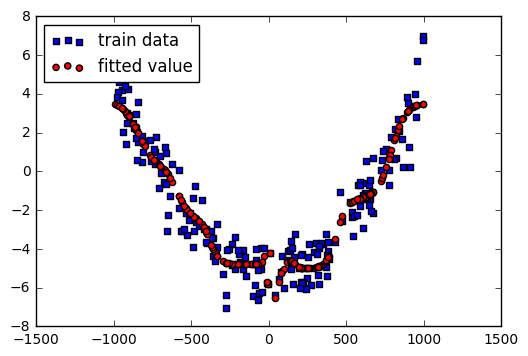

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X, y, c='b', marker="s", label='train data')
ax1.scatter(X, y_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()

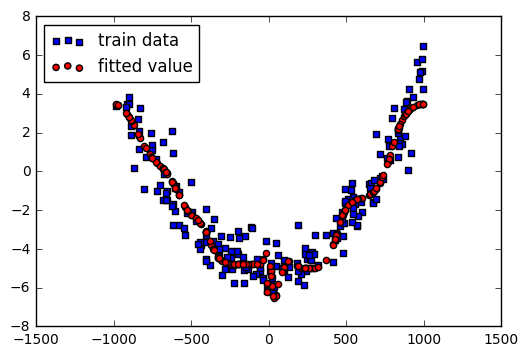

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test, y_test, c='b', marker="s", label='train data')
ax1.scatter(X_test, y_test_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()

# Bottle-neck model:

In [17]:
def build_NIN_model(input_var, hidden_neurons=1024, bottle_neck=64):
    l_in = InputLayer(shape=(None, 1), input_var=input_var)
    l_hidden1 = DenseLayer(l_in, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_b = DenseLayer(l_hidden1, num_units=bottle_neck, nonlinearity=None)
    l_hidden2 = DenseLayer(l_b, num_units=hidden_neurons, nonlinearity=lasagne.nonlinearities.tanh)
    l_out = DenseLayer(l_hidden1, num_units=1, nonlinearity=None)
    return l_out

In [18]:
    Batch_SIZE = 1
    num_epochs = 2000
    learn_rate = 0.1
    hidden_neurons = 1024
    bottle_neck = 64
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    network = build_NIN_model(input_var, hidden_neurons, bottle_neck)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    #l2_penalty = regularize_network_params(network, l2)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adagrad(loss, params, learning_rate=learn_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    get_output = theano.function([input_var], test_prediction)
    time_list = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, Batch_SIZE, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
            # Then we print the results for this epoch:
        time_delta = time.time() - start_time
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_delta))
        time_list.append(time_delta)
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, Batch_SIZE, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    final_train_err = train_err
    final_test_err = test_err 
    avg_epoch_time = np.mean(time_list)
    y_pred = get_output(X)
    y_test_pred = get_output(X_test)

Epoch 1 of 2000 took 0.075s
  training loss:		71.007997
Epoch 2 of 2000 took 0.075s
  training loss:		19.320647
Epoch 3 of 2000 took 0.077s
  training loss:		17.120881
Epoch 4 of 2000 took 0.083s
  training loss:		16.160973
Epoch 5 of 2000 took 0.076s
  training loss:		15.387469
Epoch 6 of 2000 took 0.077s
  training loss:		16.286507
Epoch 7 of 2000 took 0.098s
  training loss:		13.792997
Epoch 8 of 2000 took 0.113s
  training loss:		14.084437
Epoch 9 of 2000 took 0.111s
  training loss:		13.974871
Epoch 10 of 2000 took 0.078s
  training loss:		13.033464
Epoch 11 of 2000 took 0.074s
  training loss:		13.763904
Epoch 12 of 2000 took 0.084s
  training loss:		13.357870
Epoch 13 of 2000 took 0.108s
  training loss:		12.820086
Epoch 14 of 2000 took 0.114s
  training loss:		13.167239
Epoch 15 of 2000 took 0.096s
  training loss:		12.806021
Epoch 16 of 2000 took 0.090s
  training loss:		12.701137
Epoch 17 of 2000 took 0.109s
  training loss:		12.611045
Epoch 18 of 2000 took 0.099s
  training 

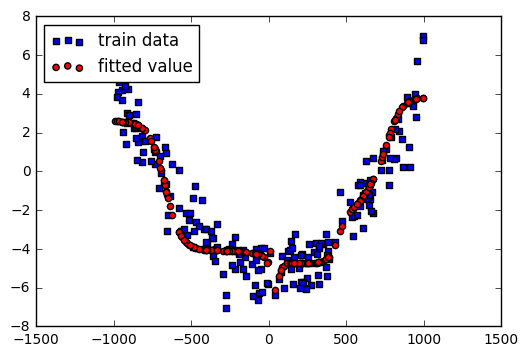

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X, y, c='b', marker="s", label='train data')
ax1.scatter(X, y_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()

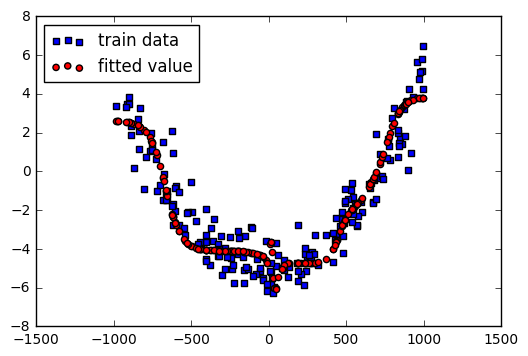

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test, y_test, c='b', marker="s", label='train data')
ax1.scatter(X_test, y_test_pred, c='r', marker="o", label='fitted value')
plt.legend(loc='upper left');
plt.show()